## Camera/ Distortion calibration

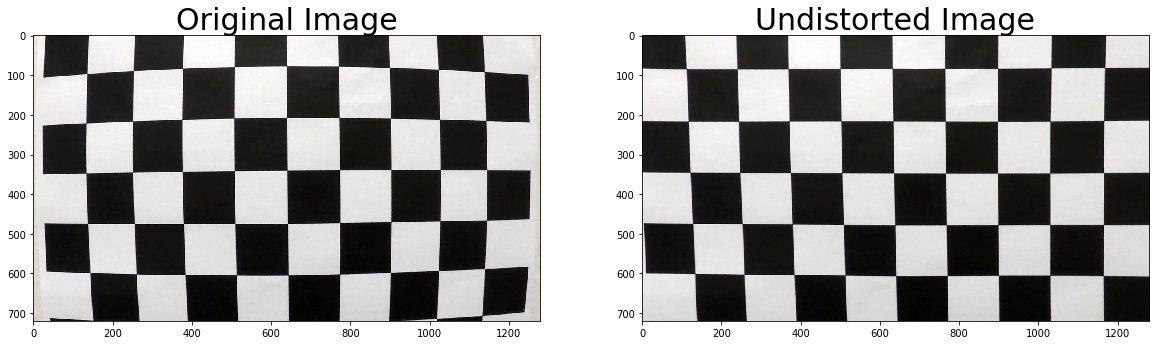

In [80]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pickle

import matplotlib.image as mpimg
%matplotlib inline

nx = 9
ny = 5

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,4,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration1*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

        
# Save mtx, dist
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./calibration_result/calibration_result_pickle.p", "wb" ) )

# Check result with a single image.
sample = mpimg.imread('./camera_cal/calibration1.jpg')
sample_undist = cv2.undistort(sample, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(sample_undist)
ax2.set_title('Undistorted Image', fontsize=30)

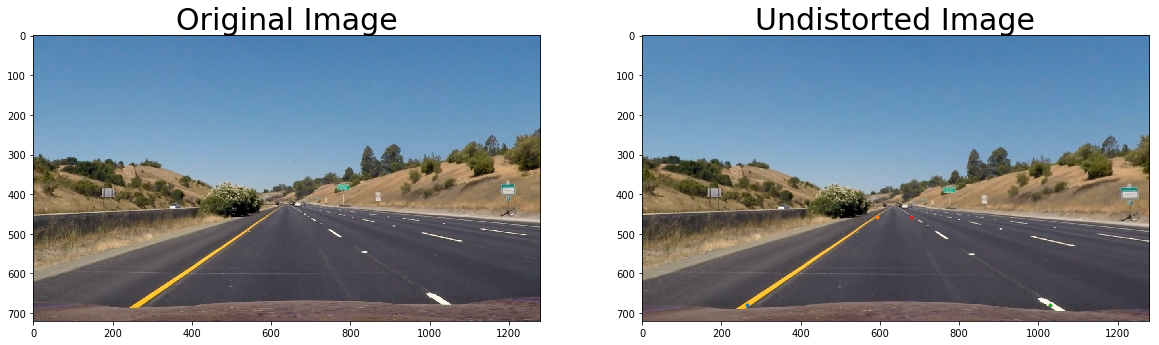

In [84]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
c_result = pickle.load(open('calibration_result/calibration_result_pickle.p','rb'))
mtx = c_result['mtx']
dist = c_result['dist']

undist = cv2.undistort(img, mtx, dist, None, mtx)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

#mpimg.imsave('./output_images/undist_straight_lines1.jpg', undist)

src_bottom_left = [264.0, 680.0]
src_upper_left = [591.8, 457.8]
src_bottom_right = [1030.5, 680.0]
src_upper_right = [679.5, 457.8]
ax2.plot(src_bottom_left[0], src_bottom_left[1], '.')
ax2.plot(src_upper_left[0], src_upper_left[1], '.')
ax2.plot(src_bottom_right[0], src_bottom_right[1], '.')
ax2.plot(src_upper_right[0], src_upper_right[1], '.')

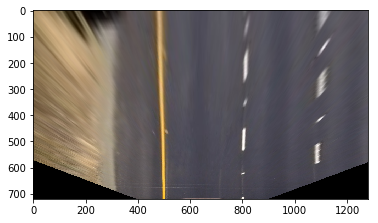

In [85]:
src = np.float32([
    src_bottom_left,
    src_upper_left,
    src_bottom_right,
    src_upper_right
])

dst_bottom_left = [500, 720]
dst_upper_left = [500,0]
dst_bottom_right = [800, 720]
dst_upper_right = [800, 0]
dst = np.float32([
    dst_bottom_left,
    dst_upper_left,
    dst_bottom_right,
    dst_upper_right
])

M = cv2.getPerspectiveTransform(src, dst)
img_size = (undist.shape[1], undist.shape[0])
warped = cv2.warpPerspective(undist, M, img_size)
plt.imshow(warped)